In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageDraw
from PIL import ImageColor
import time
from scipy.stats import norm

%matplotlib inline
plt.style.use('ggplot')

In [3]:
from collections import namedtuple
Rectangle = namedtuple('Rectangle', 'xmin ymin xmax ymax')

def min_overlap(a, b):
    dx = min(a.xmax, b.xmax) - max(a.xmin, b.xmin)
    dy = min(a.ymax, b.ymax) - max(a.ymin, b.ymin)
    if (dx>=0) and (dy>=0):
        
        return dx*dy
    else:
        return 0

def vanilla_conv_block(x, kernel_size, output_channels):
    """
    Vanilla Conv -> Batch Norm -> ReLU
    """
    x = tf.layers.conv2d(
        x, output_channels, kernel_size, (2, 2), padding='SAME')
    x = tf.layers.batch_normalization(x)
    return tf.nn.relu(x)


def mobilenet_conv_block(x, kernel_size, output_channels):
    """
    Depthwise Conv -> Batch Norm -> ReLU -> Pointwise Conv -> Batch Norm -> ReLU
    """
    # assumes BHWC format
    input_channel_dim = x.get_shape().as_list()[-1] 
    W = tf.Variable(tf.truncated_normal((kernel_size, kernel_size, input_channel_dim, 1)))

    # depthwise conv
    x = tf.nn.depthwise_conv2d(x, W, (1, 2, 2, 1), padding='SAME')
    x = tf.layers.batch_normalization(x)
    x = tf.nn.relu(x)

    # pointwise conv
    x = tf.layers.conv2d(x, output_channels, (1, 1), padding='SAME')
    x = tf.layers.batch_normalization(x)
    return tf.nn.relu(x)

In [4]:
# constants but you can change them so I guess they're not so constant :)
INPUT_CHANNELS = 32
OUTPUT_CHANNELS = 512
KERNEL_SIZE = 3
IMG_HEIGHT = 256
IMG_WIDTH = 256

with tf.Session(graph=tf.Graph()) as sess:
    # input
    x = tf.constant(np.random.randn(1, IMG_HEIGHT, IMG_WIDTH, INPUT_CHANNELS), dtype=tf.float32)

    with tf.variable_scope('vanilla'):
        vanilla_conv = vanilla_conv_block(x, KERNEL_SIZE, OUTPUT_CHANNELS)
    with tf.variable_scope('mobile'):
        mobilenet_conv = mobilenet_conv_block(x, KERNEL_SIZE, OUTPUT_CHANNELS)

    vanilla_params = [
        (v.name, np.prod(v.get_shape().as_list()))
        for v in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'vanilla')
    ]
    mobile_params = [
        (v.name, np.prod(v.get_shape().as_list()))
        for v in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'mobile')
    ]

    print("VANILLA CONV BLOCK")
    total_vanilla_params = sum([p[1] for p in vanilla_params])
    for p in vanilla_params:
        print("Variable {0}: number of params = {1}".format(p[0], p[1]))
    print("Total number of params =", total_vanilla_params)
    print()

    print("MOBILENET CONV BLOCK")
    total_mobile_params = sum([p[1] for p in mobile_params])
    for p in mobile_params:
        print("Variable {0}: number of params = {1}".format(p[0], p[1]))
    print("Total number of params =", total_mobile_params)
    print()

    print("{0:.3f}x parameter reduction".format(total_vanilla_params /
                                             total_mobile_params))

VANILLA CONV BLOCK
Variable vanilla/conv2d/kernel:0: number of params = 147456
Variable vanilla/conv2d/bias:0: number of params = 512
Variable vanilla/batch_normalization/gamma:0: number of params = 512
Variable vanilla/batch_normalization/beta:0: number of params = 512
Total number of params = 148992

MOBILENET CONV BLOCK
Variable mobile/Variable:0: number of params = 288
Variable mobile/batch_normalization/gamma:0: number of params = 32
Variable mobile/batch_normalization/beta:0: number of params = 32
Variable mobile/conv2d/kernel:0: number of params = 16384
Variable mobile/conv2d/bias:0: number of params = 512
Variable mobile/batch_normalization_1/gamma:0: number of params = 512
Variable mobile/batch_normalization_1/beta:0: number of params = 512
Total number of params = 18272

8.154x parameter reduction


In [119]:
SSD_GRAPH_FILE = 'frozen_models/faster_rcnn_inception_v2_coco_2018_01_28/frozen_inference_graph.pb'

In [138]:
# Colors (one for each class)
cmap = ImageColor.colormap
print("Number of colors =", len(cmap))
COLOR_LIST = sorted([c for c in cmap.keys()])

#
# Utility funcs
#

def filter_boxes(min_score, boxes, scores, classes):
    """Return boxes with a confidence >= `min_score`"""
    n = len(classes)
    idxs = []
    for i in range(n):
        if scores[i] >= min_score:
            idxs.append(i)
    
    filtered_boxes = boxes[idxs, ...]
    filtered_scores = scores[idxs, ...]
    filtered_classes = classes[idxs, ...]
    return filtered_boxes, filtered_scores, filtered_classes

def to_image_coords(boxes, height, width):
    """
    The original box coordinate output is normalized, i.e [0, 1].
    
    This converts it back to the original coordinate based on the image
    size.
    """
    box_coords = np.zeros_like(boxes)
    box_coords[:, 0] = boxes[:, 0] * height
    box_coords[:, 1] = boxes[:, 1] * width
    box_coords[:, 2] = boxes[:, 2] * height
    box_coords[:, 3] = boxes[:, 3] * width
    
    return box_coords

def draw_boxes(image, boxes, classes, thickness=4):
    """Draw bounding boxes on the image"""
    draw = ImageDraw.Draw(image)
    for i in range(len(boxes)):
        bot, left, top, right = boxes[i, ...]
        class_id = int(classes[i])
        color = COLOR_LIST[class_id]
        draw.line([(left, top), (left, bot), (right, bot), (right, top), (left, top)], width=thickness, fill=color)

        
def draw_box(image, r, thickness=4):
    """Draw bounding boxes on the image"""
    draw = ImageDraw.Draw(image)
    
    class_id = 10
    color = COLOR_LIST[class_id]
    draw.line([(r.xmin, r.ymin), (r.xmin, r.ymax), (r.xmax, r.ymax), (r.xmax, r.ymin), (r.xmin, r.ymin)], width=thickness, fill=color)

        
def load_graph(graph_file):
    """Loads a frozen inference graph"""
    graph = tf.Graph()
    with graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(graph_file, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    return graph

Number of colors = 148


In [121]:
detection_graph = load_graph(SSD_GRAPH_FILE)
# detection_graph = load_graph(RFCN_GRAPH_FILE)
# detection_graph = load_graph(FASTER_RCNN_GRAPH_FILE)

# The input placeholder for the image.
# `get_tensor_by_name` returns the Tensor with the associated name in the Graph.
image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

# Each box represents a part of the image where a particular object was detected.
detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

# Each score represent how level of confidence for each of the objects.
# Score is shown on the result image, together with the class label.
detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')

# The classification of the object (integer id).
detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')

In [162]:
# Load a sample image.
#image = Image.open('./images/left0607.jpg')
image_file = './images/left0034.jpg'
image = Image.open(image_file)

image_np = np.expand_dims(np.asarray(image, dtype=np.uint8), 0)

with tf.Session(graph=detection_graph) as sess:                
    # Actual detection.
    (boxes, scores, classes) = sess.run([detection_boxes, detection_scores, detection_classes], 
                                        feed_dict={image_tensor: image_np})

    # Remove unnecessary dimensions
    boxes = np.squeeze(boxes)
    scores = np.squeeze(scores)
    classes = np.squeeze(classes)

    confidence_cutoff = 0.3
    # Filter boxes with a confidence score less than `confidence_cutoff`
    boxes, scores, classes = filter_boxes(confidence_cutoff, boxes, scores, classes)

    # The current box coordinates are normalized to a range between 0 and 1.
    # This converts the coordinates actual location on the image.
    width, height = image.size
    box_coords = to_image_coords(boxes, height, width)
    
    

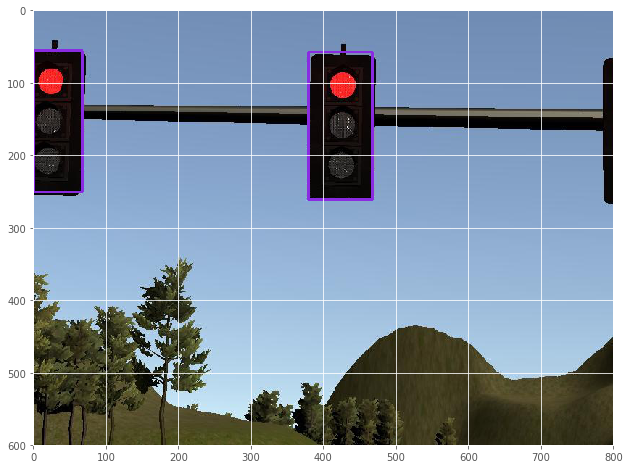

In [163]:
image = Image.open(image_file)
# Each class with be represented by a differently colored box

#for box in box_coords:
processed = []

for i in range(len(box_coords)):
    if classes[i] == 10.0: 
        top, left, bot, right = box_coords[i, ...]

        prev = processed[:]

        r = Rectangle(left, top, right, bot)

        for rect in prev:
            if min_overlap(r, rect) > 0:
                r = Rectangle(min(r.xmin, rect.xmin), min(r.ymin, rect.ymin), max(r.xmax, rect.xmax), max(r.ymax, rect.ymax))
                processed.remove(rect)
        processed.append(r)

for rect in processed:
    draw_box(image, rect)

        
#draw_boxes(image, box_coords, classes)

plt.figure(figsize=(12, 8))
plt.imshow(image)